<a href="https://colab.research.google.com/github/Sirfowahid/FFN/blob/master/FNN_FNNonMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [20]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

labels = data[:,0]
data = data[:,1:]

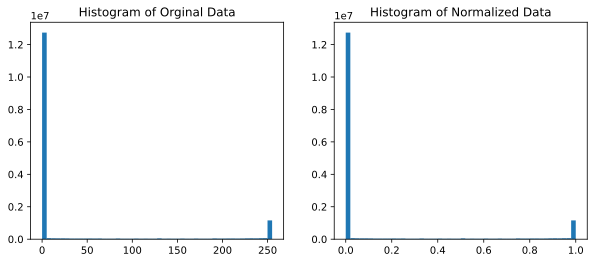

In [21]:
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].hist(data.flatten(),50)
ax[0].set_title('Histogram of Orginal Data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_title('Histogram of Normalized Data')

plt.show()

In [22]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size=.1)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [23]:
def createTheMNISTNet():

  class mnistNet(nn.Module):

    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,64)

      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      self.output = nn.Linear(32,10)

    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))

      return torch.log_softmax(self.output(x),axis = 1)

  net = mnistNet()

  lossfun = nn.NLLLoss()
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer



In [24]:
net,lossfun,optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

loss = lossfun(yHat,y)

print(loss)

tensor(2.3279, grad_fn=<NllLossBackward0>)


In [25]:
def fun2trainTheModel():

   numepochs = 100

   net,lossfun,optimizer = createTheMNISTNet()

   losses = torch.zeros(numepochs)
   trainAcc = []
   testAcc = []

   for epochi in range(numepochs):

     batchAcc = []
     batchLoss = []

     for X,y in train_loader:

       yHat = net(X)

       loss = lossfun(yHat,y)

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

       batchLoss.append(loss.item())
       matches = torch.argmax(yHat,axis=1) == y
       matchesNumeric = matches.float()
       accPct = 100*torch.mean(matchesNumeric)
       batchAcc.append(accPct)
     
     trainAcc.append(np.mean(batchAcc))
     losses[epochi] = np.mean(batchLoss)

     X,y = next(iter(test_loader))
     yHat = net(X)

     testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
   
   return trainAcc,testAcc,losses,net
   



In [26]:
trainAcc,testAcc,losses,net = fun2trainTheModel()

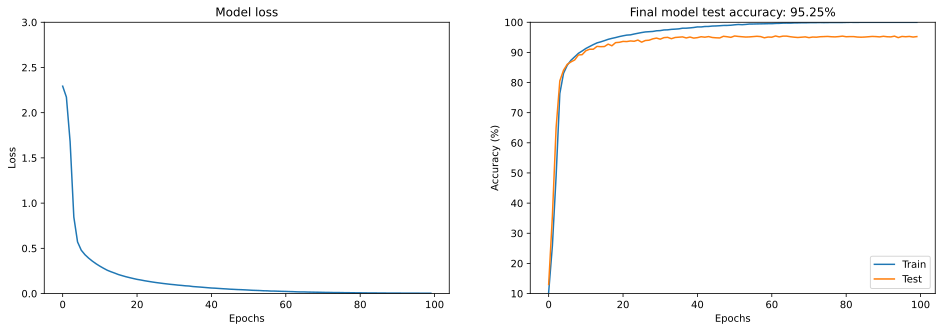

In [27]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [28]:
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-3.4244e+00, -2.4693e+01, -1.3677e+01,  ..., -3.4051e+01,
         -7.1075e-02, -1.9917e+01],
        [-2.9111e+01, -3.0268e+01, -2.2707e+01,  ..., -3.5829e+01,
          0.0000e+00, -2.1435e+01],
        [-1.1450e+01, -3.4407e+01, -2.2949e+01,  ..., -5.2860e+01,
         -1.9484e+01, -3.4652e+01],
        ...,
        [-3.7035e+01, -2.2822e+01, -2.5290e+01,  ..., -1.3364e+01,
         -2.2164e+01, -1.7912e+01],
        [-3.2954e+01, -3.4641e+01, -2.7526e+01,  ..., -2.3842e-06,
         -3.1668e+01, -1.3095e+01],
        [-3.4037e+01, -3.4566e+01, -2.8163e+01,  ..., -2.0566e+01,
         -2.6663e+01, -2.1553e+01]])

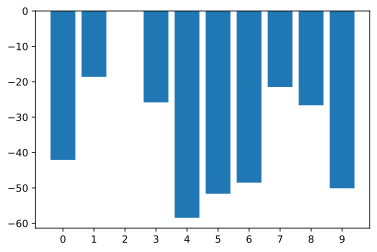

In [29]:
sample2show = 120

plt.bar(range(10),predictions[sample2show])
plt.xticks(range(10))
plt.show()

In [30]:
errors = np.where(torch.max(predictions,axis=1)[1] !=y)[0]
print(errors)

[   8   17   46  115  123  124  150  185  206  209  230  255  263  285
  287  334  335  339  345  384  397  442  446  488  508  539  552  567
  647  660  677  695  698  726  727  746  777  819  854  876 1003 1010
 1030 1031 1034 1035 1096 1112 1118 1127 1139 1169 1177 1236 1267 1303
 1308 1352 1356 1385 1403 1411 1414 1438 1439 1458 1474 1479 1487 1488
 1491 1499 1540 1551 1553 1593 1599 1613 1638 1645 1648 1650 1724 1737
 1741 1757 1765 1782 1798 1819 1905 1916 1931 1963 1970]


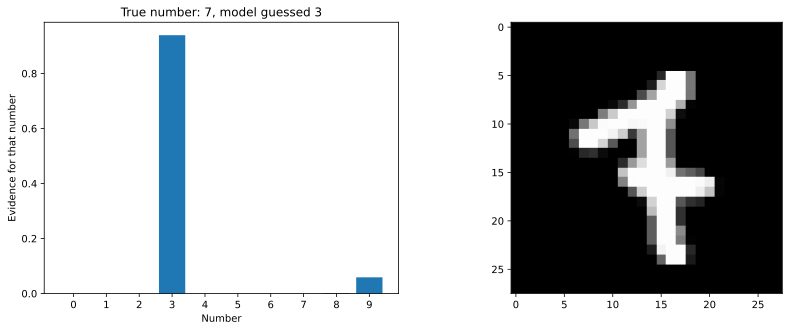

In [31]:
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')
plt.show()